# Motivating Transformers in Vision
Or, why computer vision and deep learning is fucking cool.

## Outline
1. Goals
    - Come as you are
    - We want you to leave wide eyed, having some sense of how you might go from some interesting idea in your head, **to knowing what questions to ask and potentially how to solve**.
    - We want to appeal to the generally curious, and the super-nerds. So we'll have sections you can explore.
2. Why should you even care?
    - Demos
    - Problem use cases, specific ones
    - Task focus
3. Understanding images and motivating convolutions.
    - How are images represented on a computer **NB**.
    - Spatial structure and understanding. Convs can both aggregate information and extract information. Gaussiuan and Sobel kernel. **Demo**.
        - Inductive biases: locality, 2D structure, translational equivariance, receptive field
    - Putting the "convolution" in CNNs. **Demo**.
        - Different kinds of convolutions.
    - Stacking to create DCNNs.
        - Global context aggregation
4. Tasks!
    - Classification **Demo**
    - Detection **Demo**
    - Segmentation **Demo**
    - Image-to-image translation **Demo**
    - (Conditional) generation **Demo**
    - And more!


## Goals of the Forum
1. Come as you are
2. Leave with a good sense of what to do with your innovative idea:
    - Can computer vision solve this?
    - What type of vision model might help me solve this?
    - Who should I talk to?
    - Which research papers should I read?
3. We want to appeal to the generally-curious, so we'll have references for the nerds to read more about a given topic.

## Vision and Transformers: Why Should I Care?
1. AI is becoming much more accessible:
    - [Open AI](https://openai.com/) (DALLE, GPT-3, etc)
    - [Stability AI](https://stability.ai/) (Stable Diffusion) 
    - [Midjourney](https://www.midjourney.com/home/)
    - [HuggingFace](https://huggingface.co/)
    - [NatML](https://natml.ai) (shameless plug)
2. The bottleneck has shifted from tech capabilities to creativity:
    - [Generating VR worlds with stable diffusion](https://twitter.com/ScottieFoxTTV/status/1578387866572525570?s=20&t=MfUX61jLrp6ZhCDemZUPDA)
    - [AI virtual staging with stable diffusion](https://twitter.com/levelsio/status/1580586758802022402?s=20&t=MfUX61jLrp6ZhCDemZUPDA)
    - [Generating AI art with DALLE](https://twitter.com/Dalle2AI/status/1581260890510602244?s=20&t=MfUX61jLrp6ZhCDemZUPDA)
    - Much much more...
3. We're all buillders, so:
    - We come across problems that we want to solve
    - We need to know what tools exist out there for us to solve our problems with
    - And ideally, we should have some sense of _how these tools work_. This is where the forum comes in.

## Understanding Images and Motivating Convolutions
In this module, we will explore how images are represented digitally, and how we can then build algorithms to learn from these representations.

## Representing Images
Images are just 2D (or 3D) distributions of numbers, where each number captures the pixel intensity at a given coordinate:
\begin{equation}
I(x, y): \mathbb{N} \times \mathbb{N} \rightarrow \mathbb{R}
\end{equation}
This allows us to easily represent images as matrices, or more generally, tensors. Below, we will create a checkerboard pattern image by creating a 2D matrix of zeroes, then filling every other pixel location (in both axes) with white:

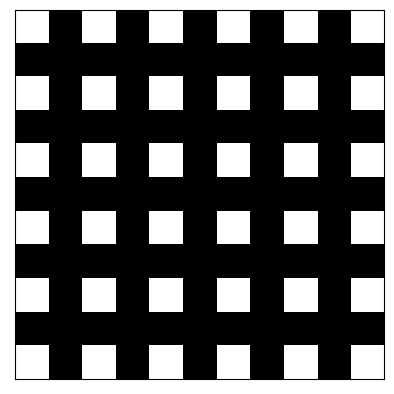

In [31]:
from numpy import linspace, zeros
from matplotlib import pyplot as plt

# Create a grey image with a checkerboard pattern
image = zeros((11, 11))
image[0::2,0::2] = 1.0

# Plot
plt.imshow(image, cmap="gray", vmin=0., vmax=1.)
plt.xticks([])
plt.yticks([])
plt.show()

In [33]:
image

array([[1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]])

Of course, the above is uninteresting. Instead, let's load an actual image that we can play with:

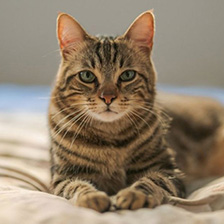

In [35]:
from PIL import Image

image = Image.open("media/cat_224.jpg")
image

Unlike the checkerboard we created above, this cat image has color. The interesting thing to note about how we understand color is that instead of keeping one intensity value for a given pixel coordinate, we keep a **vector** of intensities, each corresponding to the intensity of a component of color. We can confirm this by converting the image above into a tensor, then checking its shape:

In [38]:
from numpy import asarray

image_tensor = asarray(image)
image_tensor.shape

(224, 224, 3)

### Learning from Images with Convolutions
Now that we have some understanding of how we can represent images on a computer, a good next step is to figure out how we might go about building a set of algorithms to learn semantic concepts from images. A good place to start is human vision.

![hvs](media/hvs.png)

Source: [Wang & Raj 2017](https://arxiv.org/pdf/1702.07800.pdf).

The HVS is a hierarchical system, starting by extracting simple primitives from the image (lines and edges), then combining these primitives to build more complex primitives (shapes), then higher level concepts (faces). Perhaps the most important mathematical tool that allows us to simulate this behaviour is the **Convolution** operator.
\begin{equation}
(f * g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau
\end{equation}

Or more intuitively:

![conv1d](media/conv1d.gif)

Source: [Spatial](https://spatial-lang.org/conv).

Given that images are discrete distributions, we will be using the $n$-dimentional discrete convolution. In the 2D case:
\begin{equation}
(I * K)(x, y) = \sum_{i = -s}^{s} \sum_{j = -s}^{s} I(i+x,j+y) K(i+s,k+s)
\end{equation}
Where $K \in \mathbb{R}^{k \times k}$ is a 2D convolution kernel and $s = \lfloor k / 2 \rfloor$. Intuitively, here's what the equation above means:

![conv1d](media/conv2d.gif)

Source: [Spatial](https://spatial-lang.org/conv).

### Experimenting with Convolutions

![conv_demo](media/conv_demo.gif)

To build a more intuitive understanding of convolutions, [check out this demo on NatML](https://demos.natml.ai/@yusuf/convolutions).

## Building Convolutional Neural Networks
There's a very important insight to glean from the previous module: we can build computer vision models by training neural networks to learn a series of convolution kernels that extract features from images, then use these learnt features to solve some downstream task. In this module, we will explore the general structure of Convolutional Neural Networks, then we will explore some of the most common tasks that are solved with these models.

> The goal with this module is to provide a conceptual understanding of _what_ problems can be solved with vision models, and more interestingly, _how_ these problems are solved. As we begin to explore the use of Transformers in vision, we encourage you to ask how transformers might apply to solving the given task, at a very high level.

### CNNs in a Nutshell
Most computer vision models in deep learning have the same structure:

![cnn](media/cnn.jpeg)

Source: [Towards Data Science, 2018](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

A vision model typically consumes an image tensor, then projects it into some high dimensional, non-linear feature space which contains semantic information about the input image. This projection is achieved by learning a set of convolution kernels, and potentially non-linearities, that extract useful information from batches of images:

![features](media/features.png)

Source: [Towards Data Science, 2018](https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f).

Once the projection has been made, the feature tensor is then pushed through a sub-network that solves a downstream task. Below. we will explore some of the most common downstream tasks in applied vision.

> In each section, we will give a description of the model; a high-level overview of how models that solve the task work; a few keywords to remember; and a demo illustrating the model running in realtime.

### Image Classification
Image classication involves predicting a class label from a single image. The quintessential example of this is an image classifier trained to discern images of cats vs. dogs:

![classifier](media/classifier.gif)

Source: [Becoming Human: Artificial Intelligence Magazine, 2019](https://becominghuman.ai/debunking-convolutional-neural-networks-cnn-with-practical-examples-688284c45b85).

#### How it Works
The typical topology of a classifier is a CNN feature extractor paired with [multi-layer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron). The feature extractor projects the given image to an $n$-dimensional space, and the MLP learns a logistic distribution over the CNN feature space that best expresses the classes in the training dataset.

#### Words to Know
- **Feature extractor**: This usually refers to the part of the classifier model that only contains convolution layers, along with normalization and activation layers. This sub-network is resposible for learning a feature space from input images.

- **Classifier**: When not referring to the entire network, this usually refers to the multi-layer perceptron that projects the vision features from the feature extractor into a logistic distribution (i.e. the part of the model that actually does the classifying).

- **ResNet**: A [landmark vision architecture](https://arxiv.org/pdf/1512.03385.pdf) invented by Kaiming He (CV heavyweight) et al. which achieved SOTA results at the time, addressed some major instabilities encountered in training vision models, and is still commonly used today.

- **MobileNet**: The [go-to vision architecture](https://arxiv.org/pdf/1704.04861.pdf) for building realtime vision models, optimized for mobile applications.


#### Play with a Classifier

![classifier demo](media/classifier_demo.gif)

[Check out this demo on NatML](https://hub.natml.ai/@natsuite/mobilenet-v2?demo=true).

### Object Detection
Object detection involves finding and classifying regions of an input image as having a specific type of object.

![ssd lite](media/ssd_lite.gif)

#### How it Works
The typical topology of a detector is a CNN feature extractor followed by a detection sub-network. The detection network typically has two _heads_: a box regressor, which estimates the shape of a box; and a box classifier, which estimates the likelihood that the detected box is of a given class:

![one two stage](media/detector_one_two_stage.png)

Source: [Research Gate](https://www.researchgate.net/figure/Schematic-plot-for-a-one-stage-detector-and-b-two-stage-detector_fig1_332612704).

The box regression comes in one of two flavors: anchor-based and anchor-free. In an anchor-based detector, the detection network learns a set of offsets from a set of pre-defined boxes, called _anchors_. Pre-defining anchors is useful because it can be performed before training, and takes advantage of the fact that different objects tend to have different aspect ratios (e.g. cows tend to be longer than they are tall). In anchor-free detectors, the detection network estimates the bounds of the boxes from the center points.

![anchors](media/anchors.png)

Source: [Research Gate](https://www.researchgate.net/figure/A-visual-explanation-shows-the-difference-of-anchor-based-and-anchor-free-methods-The_fig1_348581350).

#### Words to Know
- **YOLO**. [You Only Live Once](https://arxiv.org/pdf/1506.02640.pdf). This was a SOTA single-stage object detection architecture that has stuck. It has gone through several iterations (we're up to YOLOv7 now), and still remains the go-to architecture for detection.

- **Anchors**. These are pre-defined boxes that some object detectors (e.g. YOLO v3-5) use when estimating the shape of a box.

    ![anchors](media/matlab-anchors.png)

#### Play with a Detector

![detector demo](media/detector_demo.gif)

[Check out this demo on NatML](https://demos.natml.ai/@natml/yolo-v5).

### Image-to-Image Translation
Also known as dense prediction, this is the largest and perhaps most exciting task in machine learning. Some applications include:

| Task | Example |
|:--:|:--:|
| Segmentation | ![segmentation](media/segment.jpeg) |
| (Conditional) Image Generation | ![stylegan](media/stylegan.jpeg) |
| Image Enhancement | ![enhancement](media/enhancement.png) |
| (Monocular) Depth Prediction | ![midas](media/midas.jpeg) |
| And so much more! | |

#### How it Works
These models typically work by projecting an image to a high-dimensional feature space (called "encoding"), then de-projecting the image vector back into pixel space (called "decoding"). A popular architecture for these types of problems is UNet:

![unet](media/unet.png)

Source: [Papers with Code](https://paperswithcode.com/method/u-net).

#### Words to Know
- **Latent space**. This is a high-dimensional feature space that the model learns from the training dataset. Depending on the training objective, the dimensions of the latent space could map to semantic features in the output image.

    ![latent](media/latent.gif)

- **Generative adversarial networks**. This is a class of networks trained to generate samples indistinguishable from some ground truth using adversarial learning. Adversarial learning is an unsupervised learning method where a generative model, called the _generator_, learns the underlying patterns in input data by having a separate network, called the _discriminator_, judge the generator outputs.

    ![style gan](media/stylegan-interp.gif)

#### Play with an Image Translation Model
[Check out interiorai](https://interiorai.com).
